In [ ]:
# %pip install tensorflow
# %pip instal pennylane
# %pip install matplotlib
# %pip install tqdm

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

Constants and configuration

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution"  # Data saving folder
PREPROCESS = True  # If False, skip quantum processing and load data from SAVE_PATH

Set random seeds for reproducibility

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

Load MNIST dataset

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

Reduce dataset size

In [5]:
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

Normalize pixel values

In [6]:
train_images = train_images / 255
test_images = test_images / 255

Add channel dimension for compatibility with Quantum Circuit

In [7]:
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Quantum device setup

In [8]:
dev = qml.device("default.qubit", wires=4)

Quantum circuit definition

In [10]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def quantum_circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Quantum preprocessing function

In [11]:
def quantum_preprocess(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = quantum_circuit([
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ])
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Perform quantum preprocessing if enabled

In [12]:
if PREPROCESS:
    print("Quantum pre-processing of train images:")
    q_train_images = [quantum_preprocess(img) for img in tqdm(train_images, desc="Train Images")]
    q_train_images = np.array(q_train_images)

    print("\nQuantum pre-processing of test images:")
    q_test_images = [quantum_preprocess(img) for img in tqdm(test_images, desc="Test Images")]
    q_test_images = np.array(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "_q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "_q_test_images.npy", q_test_images)
else:
    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "_q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "_q_test_images.npy")

Quantum pre-processing of train images:


Train Images: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]



Quantum pre-processing of test images:


Test Images: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


Model definition function

In [13]:
def create_model():
    """Initializes and returns a custom Keras model ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Function to train the model

In [14]:
def train_model(model, train_data, train_labels, val_data, val_labels, batch_size, n_epochs):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(n_epochs):
        # Training
        pbar = tqdm(enumerate(train_dataset), total=len(train_dataset), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch")
        for step, (x_batch, y_batch) in pbar:
            loss, accuracy = model.train_on_batch(x_batch, y_batch)
            pbar.set_postfix({"loss": loss, "accuracy": accuracy})
        
        # Validation
        val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
        history["loss"].append(loss)
        history["accuracy"].append(accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        print(f"\nEpoch {epoch+1}/{n_epochs}: val_loss={val_loss}, val_accuracy={val_accuracy}")
    
    return history

Train the quantum model

In [15]:
q_model = create_model()
q_history = train_model(
    q_model,
    q_train_images,
    train_labels,
    q_test_images,
    test_labels,
    batch_size=4,
    n_epochs=n_epochs
)

Epoch 1/30:  31%|███       | 4/13 [00:01<00:02,  3.95batch/s, loss=2.3340182, accuracy=0.1875]    

Epoch 1/30:  38%|███▊      | 5/13 [00:01<00:01,  4.59batch/s, loss=2.5727453, accuracy=0.15]  

Epoch 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.29batch/s, loss=2.519469, accuracy=0.18]       



Epoch 1/30: val_loss=2.131152629852295, val_accuracy=0.13333334028720856


Epoch 2/30: 100%|██████████| 13/13 [00:02<00:00,  5.36batch/s, loss=1.9472554, accuracy=0.2625]    



Epoch 2/30: val_loss=1.943186640739441, val_accuracy=0.30000001192092896


Epoch 3/30: 100%|██████████| 13/13 [00:02<00:00,  5.46batch/s, loss=1.642546, accuracy=0.5375]     



Epoch 3/30: val_loss=1.6715924739837646, val_accuracy=0.46666666865348816


Epoch 4/30: 100%|██████████| 13/13 [00:02<00:00,  5.70batch/s, loss=1.327701, accuracy=0.7]       



Epoch 4/30: val_loss=1.568581461906433, val_accuracy=0.5666666626930237


Epoch 5/30: 100%|██████████| 13/13 [00:02<00:00,  5.91batch/s, loss=1.1556289, accuracy=0.7875]    



Epoch 5/30: val_loss=1.471014142036438, val_accuracy=0.5666666626930237


Epoch 6/30: 100%|██████████| 13/13 [00:02<00:00,  6.49batch/s, loss=1.0127684, accuracy=0.8125]    



Epoch 6/30: val_loss=1.3835407495498657, val_accuracy=0.6333333253860474


Epoch 7/30: 100%|██████████| 13/13 [00:02<00:00,  5.86batch/s, loss=0.89809686, accuracy=0.85]      



Epoch 7/30: val_loss=1.324560284614563, val_accuracy=0.6333333253860474


Epoch 8/30: 100%|██████████| 13/13 [00:02<00:00,  6.00batch/s, loss=0.8137187, accuracy=0.85]      



Epoch 8/30: val_loss=1.2733899354934692, val_accuracy=0.6666666865348816


Epoch 9/30: 100%|██████████| 13/13 [00:02<00:00,  6.15batch/s, loss=0.74614215, accuracy=0.875]     



Epoch 9/30: val_loss=1.23176109790802, val_accuracy=0.6666666865348816


Epoch 10/30: 100%|██████████| 13/13 [00:02<00:00,  5.95batch/s, loss=0.69214606, accuracy=0.875]    



Epoch 10/30: val_loss=1.1981569528579712, val_accuracy=0.6666666865348816


Epoch 11/30: 100%|██████████| 13/13 [00:02<00:00,  6.04batch/s, loss=0.6487329, accuracy=0.875]      



Epoch 11/30: val_loss=1.1693710088729858, val_accuracy=0.6666666865348816


Epoch 12/30: 100%|██████████| 13/13 [00:02<00:00,  6.28batch/s, loss=0.6129549, accuracy=0.875]     



Epoch 12/30: val_loss=1.145160436630249, val_accuracy=0.6666666865348816


Epoch 13/30: 100%|██████████| 13/13 [00:02<00:00,  6.28batch/s, loss=0.58333385, accuracy=0.875]    



Epoch 13/30: val_loss=1.1244839429855347, val_accuracy=0.6666666865348816


Epoch 14/30: 100%|██████████| 13/13 [00:02<00:00,  5.75batch/s, loss=0.5585223, accuracy=0.875]      



Epoch 14/30: val_loss=1.106595754623413, val_accuracy=0.6666666865348816


Epoch 15/30: 100%|██████████| 13/13 [00:02<00:00,  6.11batch/s, loss=0.53751826, accuracy=0.875]    



Epoch 15/30: val_loss=1.0910601615905762, val_accuracy=0.6666666865348816


Epoch 16/30: 100%|██████████| 13/13 [00:02<00:00,  5.38batch/s, loss=0.51960325, accuracy=0.875]    



Epoch 16/30: val_loss=1.077427625656128, val_accuracy=0.6666666865348816


Epoch 17/30: 100%|██████████| 13/13 [00:02<00:00,  6.16batch/s, loss=0.5041832, accuracy=0.875]     



Epoch 17/30: val_loss=1.065390706062317, val_accuracy=0.6666666865348816


Epoch 18/30: 100%|██████████| 13/13 [00:02<00:00,  5.72batch/s, loss=0.49081144, accuracy=0.875]    



Epoch 18/30: val_loss=1.0547071695327759, val_accuracy=0.6666666865348816


Epoch 19/30: 100%|██████████| 13/13 [00:02<00:00,  5.95batch/s, loss=0.47913766, accuracy=0.875]    



Epoch 19/30: val_loss=1.0451678037643433, val_accuracy=0.6666666865348816


Epoch 20/30: 100%|██████████| 13/13 [00:02<00:00,  5.43batch/s, loss=0.46887794, accuracy=0.875]     



Epoch 20/30: val_loss=1.0366095304489136, val_accuracy=0.6666666865348816


Epoch 21/30: 100%|██████████| 13/13 [00:02<00:00,  5.07batch/s, loss=0.45980722, accuracy=0.875]    



Epoch 21/30: val_loss=1.0288993120193481, val_accuracy=0.699999988079071


Epoch 22/30: 100%|██████████| 13/13 [00:02<00:00,  4.71batch/s, loss=0.45174402, accuracy=0.8875]    



Epoch 22/30: val_loss=1.0219238996505737, val_accuracy=0.699999988079071


Epoch 23/30: 100%|██████████| 13/13 [00:02<00:00,  5.21batch/s, loss=0.44453964, accuracy=0.8875]    



Epoch 23/30: val_loss=1.0155903100967407, val_accuracy=0.699999988079071


Epoch 24/30: 100%|██████████| 13/13 [00:02<00:00,  4.77batch/s, loss=0.43807262, accuracy=0.8875]    



Epoch 24/30: val_loss=1.0098204612731934, val_accuracy=0.699999988079071


Epoch 25/30: 100%|██████████| 13/13 [00:03<00:00,  4.01batch/s, loss=0.43224254, accuracy=0.8875]    



Epoch 25/30: val_loss=1.004548192024231, val_accuracy=0.699999988079071


Epoch 26/30: 100%|██████████| 13/13 [00:03<00:00,  3.89batch/s, loss=0.4269659, accuracy=0.8875]     



Epoch 26/30: val_loss=0.9997165203094482, val_accuracy=0.699999988079071


Epoch 27/30: 100%|██████████| 13/13 [00:03<00:00,  4.21batch/s, loss=0.42217237, accuracy=0.8875]    



Epoch 27/30: val_loss=0.9952774047851562, val_accuracy=0.699999988079071


Epoch 28/30: 100%|██████████| 13/13 [00:02<00:00,  5.08batch/s, loss=0.417803, accuracy=0.8875]      



Epoch 28/30: val_loss=0.9911895394325256, val_accuracy=0.699999988079071


Epoch 29/30: 100%|██████████| 13/13 [00:02<00:00,  5.77batch/s, loss=0.41380796, accuracy=0.8875]    



Epoch 29/30: val_loss=0.9874160885810852, val_accuracy=0.699999988079071


Epoch 30/30: 100%|██████████| 13/13 [00:02<00:00,  5.23batch/s, loss=0.41014427, accuracy=0.8875]    


Epoch 30/30: val_loss=0.9839264154434204, val_accuracy=0.699999988079071


Train the classical model for comparison

In [16]:
c_model = create_model()
c_history = train_model(
    c_model,
    train_images,
    train_labels,
    test_images,
    test_labels,
    batch_size=4,
    n_epochs=n_epochs
)

Epoch 1/30: 100%|██████████| 13/13 [00:03<00:00,  3.73batch/s, loss=2.308749, accuracy=0.08]       



Epoch 1/30: val_loss=2.178947925567627, val_accuracy=0.23333333432674408


Epoch 2/30: 100%|██████████| 13/13 [00:02<00:00,  6.18batch/s, loss=2.0003006, accuracy=0.325]     



Epoch 2/30: val_loss=1.9981824159622192, val_accuracy=0.30000001192092896


Epoch 3/30: 100%|██████████| 13/13 [00:01<00:00,  6.65batch/s, loss=1.757654, accuracy=0.475]      



Epoch 3/30: val_loss=1.8489080667495728, val_accuracy=0.3333333432674408


Epoch 4/30: 100%|██████████| 13/13 [00:02<00:00,  6.42batch/s, loss=1.559745, accuracy=0.6]       



Epoch 4/30: val_loss=1.7234668731689453, val_accuracy=0.36666667461395264


Epoch 5/30: 100%|██████████| 13/13 [00:02<00:00,  5.83batch/s, loss=1.3943336, accuracy=0.65]      



Epoch 5/30: val_loss=1.6195539236068726, val_accuracy=0.5


Epoch 6/30: 100%|██████████| 13/13 [00:02<00:00,  6.42batch/s, loss=1.2564838, accuracy=0.7375]   



Epoch 6/30: val_loss=1.5329781770706177, val_accuracy=0.5333333611488342


Epoch 7/30: 100%|██████████| 13/13 [00:02<00:00,  6.03batch/s, loss=1.1412686, accuracy=0.75]      



Epoch 7/30: val_loss=1.4597352743148804, val_accuracy=0.6000000238418579


Epoch 8/30: 100%|██████████| 13/13 [00:02<00:00,  6.28batch/s, loss=1.0442843, accuracy=0.8]      



Epoch 8/30: val_loss=1.3970787525177002, val_accuracy=0.6333333253860474


Epoch 9/30: 100%|██████████| 13/13 [00:02<00:00,  5.55batch/s, loss=0.9621307, accuracy=0.8375]    



Epoch 9/30: val_loss=1.3431916236877441, val_accuracy=0.6333333253860474


Epoch 10/30: 100%|██████████| 13/13 [00:02<00:00,  4.78batch/s, loss=0.89222157, accuracy=0.8375]   



Epoch 10/30: val_loss=1.296708583831787, val_accuracy=0.6666666865348816


Epoch 11/30: 100%|██████████| 13/13 [00:02<00:00,  5.60batch/s, loss=0.8325032, accuracy=0.85]       



Epoch 11/30: val_loss=1.2564847469329834, val_accuracy=0.6666666865348816


Epoch 12/30: 100%|██████████| 13/13 [00:02<00:00,  5.82batch/s, loss=0.7812838, accuracy=0.8625]    



Epoch 12/30: val_loss=1.221534013748169, val_accuracy=0.6666666865348816


Epoch 13/30: 100%|██████████| 13/13 [00:02<00:00,  5.41batch/s, loss=0.73715544, accuracy=0.875]    



Epoch 13/30: val_loss=1.1910183429718018, val_accuracy=0.6666666865348816


Epoch 14/30: 100%|██████████| 13/13 [00:02<00:00,  5.40batch/s, loss=0.69895077, accuracy=0.875]     



Epoch 14/30: val_loss=1.1642392873764038, val_accuracy=0.6666666865348816


Epoch 15/30: 100%|██████████| 13/13 [00:02<00:00,  4.86batch/s, loss=0.6657084, accuracy=0.875]      



Epoch 15/30: val_loss=1.1406207084655762, val_accuracy=0.6666666865348816


Epoch 16/30: 100%|██████████| 13/13 [00:02<00:00,  5.66batch/s, loss=0.63663924, accuracy=0.875]    



Epoch 16/30: val_loss=1.119688868522644, val_accuracy=0.699999988079071


Epoch 17/30: 100%|██████████| 13/13 [00:02<00:00,  5.29batch/s, loss=0.6110965, accuracy=0.8875]     



Epoch 17/30: val_loss=1.1010531187057495, val_accuracy=0.699999988079071


Epoch 18/30: 100%|██████████| 13/13 [00:02<00:00,  5.32batch/s, loss=0.5885476, accuracy=0.8875]    



Epoch 18/30: val_loss=1.0843900442123413, val_accuracy=0.6666666865348816


Epoch 19/30: 100%|██████████| 13/13 [00:02<00:00,  5.43batch/s, loss=0.5685536, accuracy=0.875]      



Epoch 19/30: val_loss=1.0694302320480347, val_accuracy=0.6666666865348816


Epoch 20/30: 100%|██████████| 13/13 [00:02<00:00,  4.67batch/s, loss=0.5507506, accuracy=0.875]     



Epoch 20/30: val_loss=1.0559481382369995, val_accuracy=0.699999988079071


Epoch 21/30: 100%|██████████| 13/13 [00:02<00:00,  5.58batch/s, loss=0.5348347, accuracy=0.8875]    



Epoch 21/30: val_loss=1.0437535047531128, val_accuracy=0.699999988079071


Epoch 22/30: 100%|██████████| 13/13 [00:03<00:00,  4.30batch/s, loss=0.5205523, accuracy=0.8875]     



Epoch 22/30: val_loss=1.03268563747406, val_accuracy=0.699999988079071


Epoch 23/30: 100%|██████████| 13/13 [00:02<00:00,  5.34batch/s, loss=0.50768936, accuracy=0.8875]    



Epoch 23/30: val_loss=1.022607445716858, val_accuracy=0.699999988079071


Epoch 24/30: 100%|██████████| 13/13 [00:02<00:00,  5.57batch/s, loss=0.49606523, accuracy=0.8875]   



Epoch 24/30: val_loss=1.0134022235870361, val_accuracy=0.699999988079071


Epoch 25/30: 100%|██████████| 13/13 [00:02<00:00,  5.22batch/s, loss=0.4855264, accuracy=0.8875]     



Epoch 25/30: val_loss=1.0049697160720825, val_accuracy=0.699999988079071


Epoch 26/30: 100%|██████████| 13/13 [00:02<00:00,  5.45batch/s, loss=0.47594213, accuracy=0.8875]   



Epoch 26/30: val_loss=0.9972237348556519, val_accuracy=0.699999988079071


Epoch 27/30: 100%|██████████| 13/13 [00:02<00:00,  5.52batch/s, loss=0.46720043, accuracy=0.8875]    



Epoch 27/30: val_loss=0.9900899529457092, val_accuracy=0.699999988079071


Epoch 28/30: 100%|██████████| 13/13 [00:02<00:00,  5.17batch/s, loss=0.45920467, accuracy=0.8875]    



Epoch 28/30: val_loss=0.9835036396980286, val_accuracy=0.699999988079071


Epoch 29/30: 100%|██████████| 13/13 [00:02<00:00,  5.42batch/s, loss=0.4518722, accuracy=0.8875]     



Epoch 29/30: val_loss=0.9774084687232971, val_accuracy=0.699999988079071


Epoch 30/30: 100%|██████████| 13/13 [00:02<00:00,  5.21batch/s, loss=0.44513068, accuracy=0.8875]    


Epoch 30/30: val_loss=0.9717556238174438, val_accuracy=0.699999988079071


Plotting accuracy and loss comparison

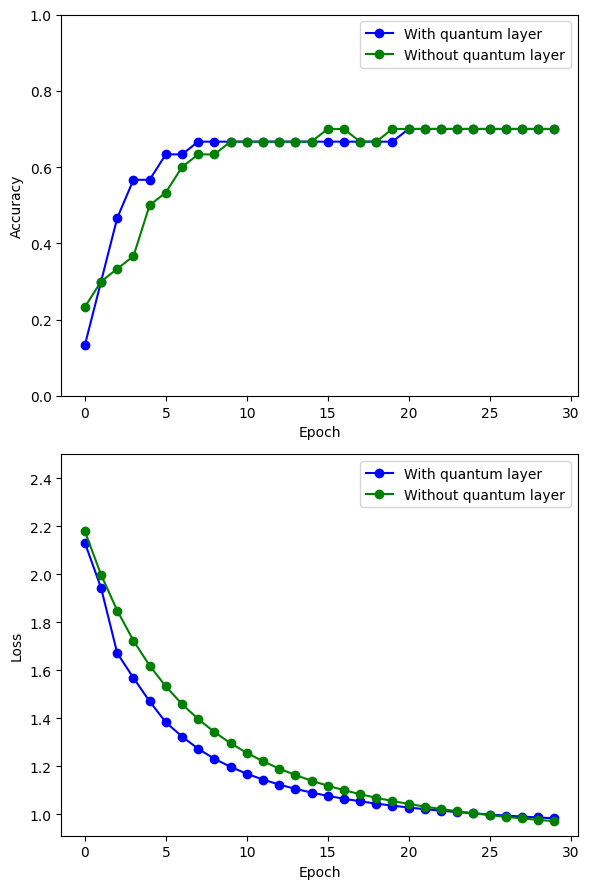

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()